# Model Training

### Import libraries

In [151]:
#import python libraries for data manipulation
import numpy as np # matrix manipulation
import pandas as pd
import sklearn.metrics as metrics # measuring metrics
import matplotlib.pyplot as plt # image and plot results

In [152]:



#import tensorflow as tf

#model library
#from tensorflow.keras.models import Sequential 

#layers library

from tensorflow.keras.layers import Dropout


In [153]:
# tensorflow libraries

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler # checkpoints
from tensorflow.keras.models import Model # creating the model
from tensorflow.keras.layers import Input # generating TF inputs
from tensorflow.keras.layers import Dense # layer densification
from tensorflow.keras.layers import Flatten # layer flattening
from tensorflow.keras.layers import Conv2D # 2D convolution
from tensorflow.keras.layers import BatchNormalization # for Batch Normalization
from tensorflow.keras.layers import Activation #
#from tensorflow.keras.layers import MaxPooling2D # max pooling conv
from tensorflow.keras.layers import AveragePooling2D # Average pooling conv
from tensorflow.keras.layers import add # adding layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical # converting lables to categorial
#from tensorflow.keras.datasets import cifar10 # cifar10, 10 class pic database
from tensorflow.keras import optimizers # NN optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator # generating image varaints

from keras.layers import LeakyReLU
#optimizer
from tensorflow.keras import optimizers
from keras.optimizers import Adam

#model printing
from tensorflow.keras.utils import plot_model

In [154]:
import matplotlib.pyplot as plt
import os
import random

In [155]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16007926329773863038
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6622735237
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15924165685025908161
physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


### Load Data

In [156]:
data = np.load('data_norm.npy')
labels = np.load('labels.npy')
labels_binary = to_categorical(labels)

In [157]:
data.shape

(3396, 96, 96, 3)

In [158]:
# 80% data is training
trLen = round(0.8*(data.shape[0]))

In [159]:
trDat = data[0:trLen]
tsDat = data[trLen:]
trLbl = labels_binary[0:trLen]
tsLbl = labels_binary[trLen:]

print(tsLbl.shape)

(679, 2)


### Create Model

In [189]:

# Seeding and optimizer selection

seed        = 29
np.random.seed(seed)

optmz       = optimizers.Adam(lr=0.001)
modelname   = 'Ajay_Singh_Snake_ResV1_3DS'

In [202]:

# define the deep learning model

# define the ResNet blocks

# resLyr block enabling different types of layer stacking
#reslyr stacks simple NN layers based on inputs. Invoked by resblock
def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):
    
    x = inputs
    
    convLyr = Conv2D(numFilters,
                    kernel_size=kernelSz,
                    strides=strides,
                    padding='same',
                    kernel_initializer='he_normal',
                    kernel_regularizer=l2(1e-4),
                    name=lyrName+'_conv' if lyrName else None)
    
    if convFirst:
        #first layer as conv2D block 
        x = convLyr(x)
        #x= Dropout(0.1)(x)
        if batchNorm:
            #then batchnorm
            
            x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
            #x= Dropout(0.5)(x)
        if activation is not None:
            #then relevant activation
            
            x = Activation(activation,name=lyrName+'_'+activation if lyrName else None)(x)
            #x= Dropout(0.5)(x)
            
    else:
        #first layer as NON-Conv2D block 
        if batchNorm:
            #first layer as batchNorm block 
            
            x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
            #x= Dropout(0.5)(x)
        if activation is not None:
            #then relevant activation
            x = Activation(activation,name=lyrName+'_'+activation if lyrName else None)(x)
            #x= Dropout(0.5)(x)
        x = convLyr(x)
       # x= Dropout(0.1)(x)
  
    return x
    

In [203]:
#ResBlock defines blocks of Simple and Down resblocks
def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
    x = inputs
    
    for run in range(0,numBlocks):
        strides = 1
        blkStr = str(run+1)
        if downsampleOnFirst and run == 0:
            strides = 2
        
        y = resLyr(inputs=x,
                  numFilters=numFilters,
                  strides=strides,
                  lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        
        y = resLyr(inputs=y,
                  numFilters=numFilters,
                  activation=None,
                  lyrName=names+'_Blk'+blkStr+'_Res2' if names else None)
        
        if downsampleOnFirst and run ==0:
            x = resLyr(inputs=x,
                      numFilters=numFilters,
                      kernelSz=1,
                      strides=strides,
                      activation=None,
                      batchNorm=False,
                      lyrName=names+'_Blk'+blkStr+'_lin' if names else None)
        
        x = add([x,y],name=names+'_Blk'+blkStr+'_add' if names else None)
        
        x = Activation('relu', name=names+'_Blk'+blkStr+'_relu' if names else None)(x)

    return x

In [213]:
#Create the full ResNet using the building blocks at ResBlk defined above
def createResNetV1(inputShape=(96,96,3),
                   numClasses=2):
    input = Input(shape=inputShape)
    v = resLyr(input,lyrName='Input')
    v = resBlkV1(inputs=v,
                numFilters=16,
                numBlocks=5,
                downsampleOnFirst=False,
                names='Stg1')
    v = resBlkV1(inputs=v,
                numFilters=32,
                numBlocks=4,
                downsampleOnFirst=True,
                names='Stg2')
    v = resBlkV1(inputs=v,
                 numFilters=64,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg3')
    v = resBlkV1(inputs=v,
                 numFilters=128,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg4')
#     v = resBlkV1(inputs=v,
#                  numFilters=256,
#                  numBlocks=3,
#                  downsampleOnFirst=True,
#                  names='Stg5')
        
    v = AveragePooling2D(pool_size=8,
                        name='AvgPool')(v)
    #v = Dropout(0.1)(v)
    v = Flatten()(v)
    #v = Dropout(0.5)(v)
    
    outputs = Dense(numClasses,
                   activation='softmax',
                   kernel_initializer='he_normal')(v)
    
    model = Model(inputs=input,outputs=outputs)
    
    model.compile(loss='categorical_crossentropy',
                 optimizer=optmz,
                 metrics=['accuracy'])

    return model

In [214]:
# instantiate the models
                                
model       = createResNetV1()  # This is meant for training
modelGo     = createResNetV1()  # This is used for final testing

model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Input_conv (Conv2D)             (None, 96, 96, 16)   448         input_31[0][0]                   
__________________________________________________________________________________________________
Input_bn (BatchNormalization)   (None, 96, 96, 16)   64          Input_conv[0][0]                 
__________________________________________________________________________________________________
Input_relu (Activation)         (None, 96, 96, 16)   0           Input_bn[0][0]                   
___________________________________________________________________________________________

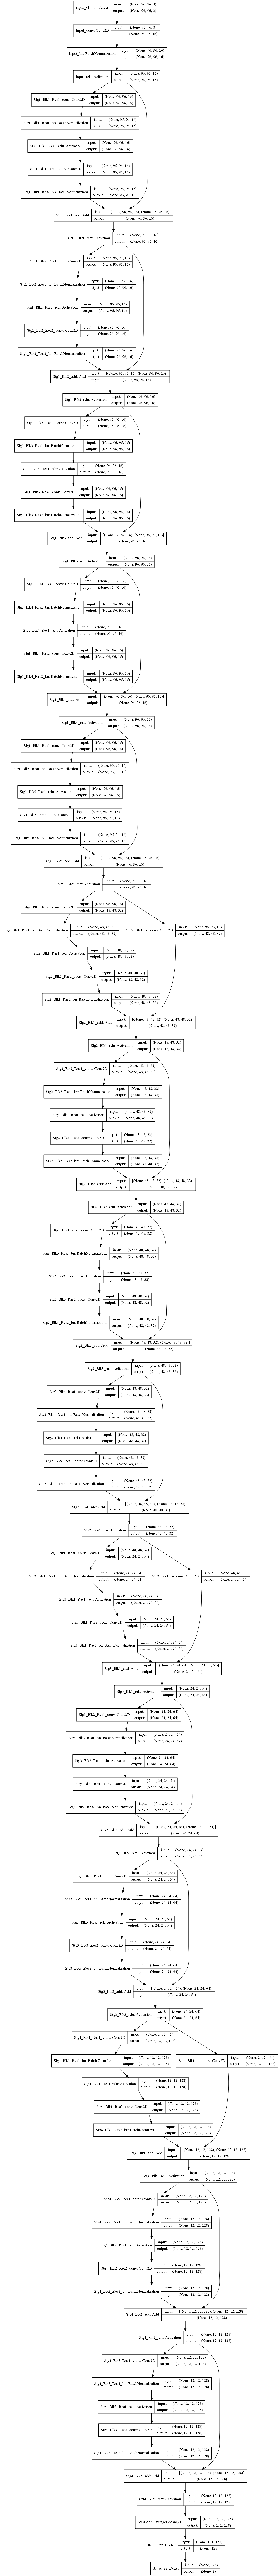

In [226]:
plot_model(model, 
           to_file=modelname+'_96x96_model_layer_names_4layer.png', 
           show_shapes=True, 
           show_layer_names=True,
           rankdir='TB')

In [219]:
# learning rate scheduler

def lrSchedule(epoch):
    lr  = 1e-3
    
    
    if epoch > 500:
        lr *= 0.5e-2
    elif epoch > 300:
        lr *= 1e-1
        
    elif epoch > 300:
        lr *= 0.5e-2
#     elif epoch > 200:
#         lr *= 1e-1
    
#     elif epoch > 160:
#         lr  *= 0.5e-2
        
#     elif epoch > 140:
#         lr  *= 1e-1
        
#     elif epoch > 120:
#         lr  *= 1e-1
        
#     elif epoch > 80:
#         lr  *= 1e-1
        
    print('Learning rate: ', lr)
    
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)

In [220]:

# Create checkpoint for the training
# This checkpoint performs model saving when
# an epoch gives highest testing accuracy

filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger,LRScheduler]

In [221]:
# data generator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             rotation_range=20,
                             horizontal_flip=True,
                             vertical_flip=False)

In [222]:
# Fit the model

model.fit_generator(datagen.flow(trDat, trLbl, batch_size=32),
                    validation_data=(tsDat, tsLbl),
                    epochs=600, 
                    verbose=1,
                    steps_per_epoch=len(trDat)/32,
                    callbacks=callbacks_list)

Learning rate:  0.001
Epoch 1/600
85/84 [==============================] - 115s 1s/step - loss: 1.3678 - acc: 0.5002 - val_loss: 1.3997 - val_acc: 0.5346
Learning rate:  0.001
Epoch 2/600
85/84 [==============================] - 10s 119ms/step - loss: 1.0745 - acc: 0.5175 - val_loss: 1.0321 - val_acc: 0.4801
Learning rate:  0.001
Epoch 3/600
85/84 [==============================] - 10s 119ms/step - loss: 1.0190 - acc: 0.5385 - val_loss: 0.9847 - val_acc: 0.5110
Learning rate:  0.001
Epoch 4/600
85/84 [==============================] - 10s 119ms/step - loss: 0.9791 - acc: 0.5381 - val_loss: 0.9576 - val_acc: 0.5302
Learning rate:  0.001
Epoch 5/600
85/84 [==============================] - 10s 118ms/step - loss: 0.9353 - acc: 0.5436 - val_loss: 0.9357 - val_acc: 0.5184
Learning rate:  0.001
Epoch 6/600
85/84 [==============================] - 10s 117ms/step - loss: 0.9173 - acc: 0.5473 - val_loss: 0.9019 - val_acc: 0.5155
Learning rate:  0.001
Epoch 7/600
85/84 [=========================

85/84 [==============================] - 10s 120ms/step - loss: 0.6928 - acc: 0.6202 - val_loss: 0.7359 - val_acc: 0.5390
Learning rate:  0.001
Epoch 54/600
85/84 [==============================] - 10s 119ms/step - loss: 0.6898 - acc: 0.6102 - val_loss: 0.7241 - val_acc: 0.5405
Learning rate:  0.001
Epoch 55/600
85/84 [==============================] - 10s 120ms/step - loss: 0.6990 - acc: 0.6021 - val_loss: 0.7264 - val_acc: 0.5567
Learning rate:  0.001
Epoch 56/600
85/84 [==============================] - 10s 122ms/step - loss: 0.6914 - acc: 0.5999 - val_loss: 0.7170 - val_acc: 0.5302
Learning rate:  0.001
Epoch 57/600
85/84 [==============================] - 10s 120ms/step - loss: 0.6875 - acc: 0.6132 - val_loss: 0.8719 - val_acc: 0.5199
Learning rate:  0.001
Epoch 58/600
85/84 [==============================] - 10s 119ms/step - loss: 0.6964 - acc: 0.6209 - val_loss: 0.8471 - val_acc: 0.4993
Learning rate:  0.001
Epoch 59/600
85/84 [==============================] - 10s 120ms/step - 

85/84 [==============================] - 10s 120ms/step - loss: 0.6483 - acc: 0.6500 - val_loss: 0.6968 - val_acc: 0.5626
Learning rate:  0.001
Epoch 106/600
85/84 [==============================] - 10s 120ms/step - loss: 0.6482 - acc: 0.6478 - val_loss: 0.7070 - val_acc: 0.5685
Learning rate:  0.001
Epoch 107/600
85/84 [==============================] - 10s 120ms/step - loss: 0.6474 - acc: 0.6474 - val_loss: 0.7229 - val_acc: 0.5685
Learning rate:  0.001
Epoch 108/600
85/84 [==============================] - 10s 122ms/step - loss: 0.6495 - acc: 0.6448 - val_loss: 0.7168 - val_acc: 0.5641
Learning rate:  0.001
Epoch 109/600
85/84 [==============================] - 10s 121ms/step - loss: 0.6435 - acc: 0.6540 - val_loss: 0.7573 - val_acc: 0.5405
Learning rate:  0.001
Epoch 110/600
85/84 [==============================] - 10s 120ms/step - loss: 0.6484 - acc: 0.6481 - val_loss: 0.7700 - val_acc: 0.5641
Learning rate:  0.001
Epoch 111/600
85/84 [==============================] - 10s 120ms/s

85/84 [==============================] - 10s 119ms/step - loss: 0.6226 - acc: 0.6754 - val_loss: 0.7233 - val_acc: 0.5655
Learning rate:  0.001
Epoch 158/600
85/84 [==============================] - 10s 120ms/step - loss: 0.6191 - acc: 0.6776 - val_loss: 0.7080 - val_acc: 0.5862
Learning rate:  0.001
Epoch 159/600
85/84 [==============================] - 10s 121ms/step - loss: 0.6210 - acc: 0.6805 - val_loss: 0.7670 - val_acc: 0.5685
Learning rate:  0.001
Epoch 160/600
85/84 [==============================] - 10s 120ms/step - loss: 0.6121 - acc: 0.6757 - val_loss: 0.7210 - val_acc: 0.6068
Learning rate:  0.001
Epoch 161/600
85/84 [==============================] - 10s 123ms/step - loss: 0.6193 - acc: 0.6735 - val_loss: 0.7231 - val_acc: 0.5832
Learning rate:  0.001
Epoch 162/600
85/84 [==============================] - 10s 122ms/step - loss: 0.6153 - acc: 0.6754 - val_loss: 0.7294 - val_acc: 0.5817
Learning rate:  0.001
Epoch 163/600
85/84 [==============================] - 10s 120ms/s

85/84 [==============================] - 10s 121ms/step - loss: 0.5718 - acc: 0.7162 - val_loss: 0.7409 - val_acc: 0.6024
Learning rate:  0.001
Epoch 210/600
85/84 [==============================] - 10s 119ms/step - loss: 0.5866 - acc: 0.6986 - val_loss: 0.7206 - val_acc: 0.6024
Learning rate:  0.001
Epoch 211/600
85/84 [==============================] - 10s 119ms/step - loss: 0.5816 - acc: 0.7067 - val_loss: 0.7264 - val_acc: 0.6024
Learning rate:  0.001
Epoch 212/600
85/84 [==============================] - 11s 129ms/step - loss: 0.5921 - acc: 0.7015 - val_loss: 0.6772 - val_acc: 0.6348
Learning rate:  0.001
Epoch 213/600
85/84 [==============================] - 10s 120ms/step - loss: 0.5875 - acc: 0.7000 - val_loss: 0.6779 - val_acc: 0.6348
Learning rate:  0.001
Epoch 214/600
85/84 [==============================] - 10s 122ms/step - loss: 0.5896 - acc: 0.7089 - val_loss: 0.6793 - val_acc: 0.5891
Learning rate:  0.001
Epoch 215/600
85/84 [==============================] - 10s 121ms/s

85/84 [==============================] - 10s 120ms/step - loss: 0.5547 - acc: 0.7335 - val_loss: 0.7265 - val_acc: 0.6230
Learning rate:  0.001
Epoch 262/600
85/84 [==============================] - 10s 121ms/step - loss: 0.5657 - acc: 0.7346 - val_loss: 0.7228 - val_acc: 0.6156
Learning rate:  0.001
Epoch 263/600
85/84 [==============================] - 10s 123ms/step - loss: 0.5517 - acc: 0.7372 - val_loss: 0.7370 - val_acc: 0.5862
Learning rate:  0.001
Epoch 264/600
85/84 [==============================] - 10s 120ms/step - loss: 0.5481 - acc: 0.7343 - val_loss: 0.7316 - val_acc: 0.6156
Learning rate:  0.001
Epoch 265/600
85/84 [==============================] - 10s 120ms/step - loss: 0.5580 - acc: 0.7357 - val_loss: 0.7227 - val_acc: 0.6230
Learning rate:  0.001
Epoch 266/600
85/84 [==============================] - 10s 119ms/step - loss: 0.5584 - acc: 0.7339 - val_loss: 0.7696 - val_acc: 0.5920
Learning rate:  0.001
Epoch 267/600
85/84 [==============================] - 10s 119ms/s

85/84 [==============================] - 32s 376ms/step - loss: 0.4865 - acc: 0.7803 - val_loss: 0.7430 - val_acc: 0.6392
Learning rate:  0.0001
Epoch 314/600
85/84 [==============================] - 32s 376ms/step - loss: 0.4875 - acc: 0.7781 - val_loss: 0.7474 - val_acc: 0.6392
Learning rate:  0.0001
Epoch 315/600
85/84 [==============================] - 32s 375ms/step - loss: 0.4813 - acc: 0.7766 - val_loss: 0.7535 - val_acc: 0.6318
Learning rate:  0.0001
Epoch 316/600
85/84 [==============================] - 32s 377ms/step - loss: 0.4721 - acc: 0.7902 - val_loss: 0.7631 - val_acc: 0.6289
Learning rate:  0.0001
Epoch 317/600
85/84 [==============================] - 32s 377ms/step - loss: 0.4701 - acc: 0.7814 - val_loss: 0.7424 - val_acc: 0.6348
Learning rate:  0.0001
Epoch 318/600
85/84 [==============================] - 34s 399ms/step - loss: 0.4763 - acc: 0.7902 - val_loss: 0.7459 - val_acc: 0.6377
Learning rate:  0.0001
Epoch 319/600
85/84 [==============================] - 33s 3

Learning rate:  0.0001
Epoch 365/600
85/84 [==============================] - 10s 117ms/step - loss: 0.4668 - acc: 0.7968 - val_loss: 0.7700 - val_acc: 0.6657
Learning rate:  0.0001
Epoch 366/600
85/84 [==============================] - 10s 118ms/step - loss: 0.4530 - acc: 0.8009 - val_loss: 0.7655 - val_acc: 0.6598
Learning rate:  0.0001
Epoch 367/600
85/84 [==============================] - 10s 119ms/step - loss: 0.4635 - acc: 0.8035 - val_loss: 0.7627 - val_acc: 0.6510
Learning rate:  0.0001
Epoch 368/600
85/84 [==============================] - 10s 118ms/step - loss: 0.4713 - acc: 0.7869 - val_loss: 0.7568 - val_acc: 0.6642
Learning rate:  0.0001
Epoch 369/600
85/84 [==============================] - 10s 118ms/step - loss: 0.4563 - acc: 0.8016 - val_loss: 0.7552 - val_acc: 0.6642
Learning rate:  0.0001
Epoch 370/600
85/84 [==============================] - 10s 119ms/step - loss: 0.4641 - acc: 0.7873 - val_loss: 0.7740 - val_acc: 0.6524
Learning rate:  0.0001
Epoch 371/600
85/84 [==

85/84 [==============================] - 10s 120ms/step - loss: 0.4463 - acc: 0.7990 - val_loss: 0.7874 - val_acc: 0.6598
Learning rate:  0.0001
Epoch 417/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4324 - acc: 0.8134 - val_loss: 0.7861 - val_acc: 0.6554
Learning rate:  0.0001
Epoch 418/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4413 - acc: 0.8042 - val_loss: 0.7858 - val_acc: 0.6539
Learning rate:  0.0001
Epoch 419/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4480 - acc: 0.8068 - val_loss: 0.8129 - val_acc: 0.6539
Learning rate:  0.0001
Epoch 420/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4410 - acc: 0.8009 - val_loss: 0.7976 - val_acc: 0.6421
Learning rate:  0.0001
Epoch 421/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4279 - acc: 0.8105 - val_loss: 0.8037 - val_acc: 0.6495
Learning rate:  0.0001
Epoch 422/600
85/84 [==============================] - 10s 1

Learning rate:  0.0001
Epoch 468/600
85/84 [==============================] - 10s 121ms/step - loss: 0.4132 - acc: 0.8197 - val_loss: 0.7977 - val_acc: 0.6878
Learning rate:  0.0001
Epoch 469/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4315 - acc: 0.8079 - val_loss: 0.8050 - val_acc: 0.6730
Learning rate:  0.0001
Epoch 470/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4124 - acc: 0.8134 - val_loss: 0.8650 - val_acc: 0.6524
Learning rate:  0.0001
Epoch 471/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4270 - acc: 0.8101 - val_loss: 0.7930 - val_acc: 0.6745
Learning rate:  0.0001
Epoch 472/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4231 - acc: 0.8134 - val_loss: 0.7887 - val_acc: 0.6804
Learning rate:  0.0001
Epoch 473/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4248 - acc: 0.8105 - val_loss: 0.7812 - val_acc: 0.6775
Learning rate:  0.0001
Epoch 474/600
85/84 [==

85/84 [==============================] - 10s 120ms/step - loss: 0.3998 - acc: 0.8281 - val_loss: 0.8234 - val_acc: 0.6716
Learning rate:  5e-06
Epoch 520/600
85/84 [==============================] - 10s 120ms/step - loss: 0.3984 - acc: 0.8307 - val_loss: 0.8243 - val_acc: 0.6730
Learning rate:  5e-06
Epoch 521/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4042 - acc: 0.8244 - val_loss: 0.8228 - val_acc: 0.6701
Learning rate:  5e-06
Epoch 522/600
85/84 [==============================] - 10s 120ms/step - loss: 0.3903 - acc: 0.8211 - val_loss: 0.8231 - val_acc: 0.6760
Learning rate:  5e-06
Epoch 523/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4037 - acc: 0.8303 - val_loss: 0.8225 - val_acc: 0.6745
Learning rate:  5e-06
Epoch 524/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4049 - acc: 0.8296 - val_loss: 0.8235 - val_acc: 0.6745
Learning rate:  5e-06
Epoch 525/600
85/84 [==============================] - 10s 120ms/s

85/84 [==============================] - 10s 120ms/step - loss: 0.4053 - acc: 0.8163 - val_loss: 0.8255 - val_acc: 0.6686
Learning rate:  5e-06
Epoch 572/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4007 - acc: 0.8244 - val_loss: 0.8245 - val_acc: 0.6701
Learning rate:  5e-06
Epoch 573/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4027 - acc: 0.8233 - val_loss: 0.8241 - val_acc: 0.6716
Learning rate:  5e-06
Epoch 574/600
85/84 [==============================] - 10s 120ms/step - loss: 0.3993 - acc: 0.8259 - val_loss: 0.8237 - val_acc: 0.6745
Learning rate:  5e-06
Epoch 575/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4010 - acc: 0.8292 - val_loss: 0.8221 - val_acc: 0.6745
Learning rate:  5e-06
Epoch 576/600
85/84 [==============================] - 10s 120ms/step - loss: 0.4074 - acc: 0.8270 - val_loss: 0.8258 - val_acc: 0.6716
Learning rate:  5e-06
Epoch 577/600
85/84 [==============================] - 10s 120ms/s

In [223]:
# compile the saved model

                            # Now the training is complete, we get
                            # another object to load the weights
                            # compile it, so that we can do 
                            # final evaluation on it
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

 

# Make classification on the test dataset
predicts    = modelGo.predict(tsDat)

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)
labelname   = ['non venomous snake',
               'venomous snake']

# the labels for the classfication report
testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 68.92%
                    precision    recall  f1-score   support

non venomous snake     0.6588    0.7560    0.7041       332
    venomous snake     0.7282    0.6254    0.6729       347

          accuracy                         0.6892       679
         macro avg     0.6935    0.6907    0.6885       679
      weighted avg     0.6943    0.6892    0.6881       679

[[251  81]
 [130 217]]


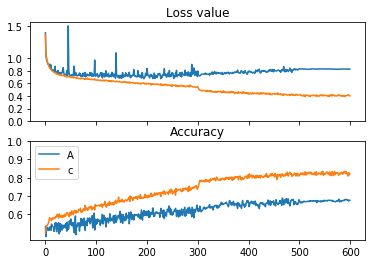

In [224]:
# Plot loss and accuracy
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()

plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0,0.20,0.40,0.60,0.80,1.00,1.5])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])




plt.subplot(212)
plt.plot(records['val_acc'])
plt.legend('Val_acc')
plt.plot(records['acc'])
plt.yticks([0.6,0.7,0.8,0.9,1.0])
plt.title('Accuracy',fontsize=12)
plt.legend('Acc')
plt.show()